# Text adventure game with Stable Diffusion
> Learn how to use Stable Diffusion in Flax and Gradio to bring to life a text-based adventure game like Zork

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [flax, vision, diffusion]

[Text adventures](https://en.wikipedia.org/wiki/Text-based_game) are text-based games wherein worlds are described in the narrative and the player submits instructions to interact with the worlds. Text-based adventure games were very popular in the 1970s and 1980s. In this article, we will bring to life one of popular games called Zork. We will use Stable Diffusion to generate images corresponding to the scenes descriptions, and [Gradio](https://gradio.app/) to interact with the user.

![zork](https://upload.wikimedia.org/wikipedia/en/a/ac/Zork_I_box_art.jpg "Credit: Zork's page on Wikipedia")

## Setup
First, let's install dependencies and import needed modules.

In [1]:
%%capture
%%bash

pip install gradio
pip install --upgrade diffusers transformers
pip install --upgrade flax

In [2]:
import numpy as np
import gradio as gr
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard

## Stable Diffusion
Second, let's initiate a Flax Stable Diffusion pipeline and download the model weights. Then define some helper function that we could use in UI to generate images.

In [3]:
%%capture
from diffusers import FlaxStableDiffusionPipeline

pipeline, pipeline_params = FlaxStableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", revision="bf16", dtype=jax.numpy.bfloat16
)

> Note: to learn more about how to use Stable Diffusion in Flax check this tutorial - [link](https://dzlab.github.io/notebooks/flax/vision/diffusion/2022/12/09/Stable_Diffusion_in_Flax_TPU.html).

In [4]:
num_samples = jax.device_count()
prng_seed = jax.random.PRNGKey(0)
prng_seed = jax.random.split(prng_seed, num_samples)
num_inference_steps = 50

params = replicate(pipeline_params)

Extract the VAE component of the pipeline, so we could use it for encoding images into their latent representation.

In [ ]:
vae, vae_params = pipeline.vae, pipeline_params['vae']

The following helper function converts the text prompt into a sequence of tokens then embed them into the latent space. 

In [5]:
def prepare_inputs(prompt, num_samples):
    prompt = num_samples * [prompt]
    prompt_ids = pipeline.prepare_inputs(prompt)
    prompt_ids = shard(prompt_ids)
    return prompt_ids

In case, we want generate images using a base image. The following helper function can be used to encode an image into a latent space.

In [6]:
def pil_to_latents(pil_image, height=768, width=768):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    image = np.asarray(pil_image)
    image = jax.image.resize(image, (height, width, 3), "bicubic")
    image = (image / 127.5 - 1.0).astype(np.float32)
    input_im = jnp.expand_dims(image, axis=0)
    input_im = jnp.transpose(input_im, (0, 3, 1, 2))
    # encode the image
    latents = vae.apply({"params": vae_params}, input_im, method=vae.encode)
    return 0.18215 * latents.latent_dist.sample(prng_seed)

This is the main function for generating images from text using the Flax Stable Diffusion pipeline. It optionally takes a PIL image that will encode (using the above `pil_to_latents` function) and use as a starting embeddings for generating a new image.

In [7]:
def generate(prompt, pil_image=None, target_height=768, target_width=768):
    prompt_ids = prepare_inputs(prompt, num_samples)
    neg_prompt_ids = prepare_inputs('ugly, low quality', num_samples)
    if pil_image:
        latents = pil_to_latents(pil_image, target_height, target_width)
        latents = jnp.transpose(latents, (0, 3, 1, 2))
        latents = jnp.expand_dims(latents, axis=0)
    else:
        latents = None
    output = pipeline(prompt_ids, params, prng_seed, num_inference_steps,
                      neg_prompt_ids=neg_prompt_ids,
                      height = target_height, width = target_width,
                      latents=latents, jit=True)
    images = output.images
    images = np.asarray(images.reshape((num_samples,) + images.shape[-3:]))
    images = pipeline.numpy_to_pil(images)
    return images

## Text-based adventure game
For the Text-based adventure game, we will implement Zork. The code is based on [this implementation](https://github.com/iamjawa/zork-py), the main difference is here we use a State Machine to implement the game. This way, the interaction with the UI/View component will be easy.

The `Zork` class implements the game as a series of stages where each stage can lead to a next one until reaching the end stage. When a user land into a stage, a welcome prompt will be printed to describe the scene. The user is then asked to submit instructions describing his next move. Based on those instructions, the user may move to the next stage or stay in the current one. The game ends when the user reaches final stage and manage to submit the correct instructions.

In [8]:
class Zork:
    def __init__(self):
        self.stage = 4
        self.end = False
    
    def welcome(self):
        lines = []
        lines.append("Welcome to Zork - The Unofficial Python Version.")
        return '\n'.join(lines)

    def _First_Input_Loop(self, second):
        stage, message = self.stage, ''
        if second.lower() == ("take mailbox"):
            message = "It is securely anchored."
        elif second.lower() == ("open mailbox"):
            message = "Opening the small mailbox reveals a leaflet."
        elif second.lower() == ("go east"):
            message = "The door is boarded and you cannot remove the boards."
        elif second.lower() == ("open door"):
            message = "The door cannot be opened."
        elif second.lower() == ("take boards"):
            message = "The boards are securely fastened."
        elif second.lower() == ("look at house"):
            message = "The house is a beautiful colonial house which is painted white. It is clear that the owners must have been extremely wealthy."
        elif second.lower() == ("go southwest"):
            stage = 8
        elif second.lower() == ("read leaflet"):
            message = "Welcome to the Unofficial Python Version of Zork. Your mission is to find a Jade Statue."
        else:
            pass
        return stage, message

    def _Southwest_Loop(self, forest_inp):
        stage, message = self.stage, ''
        if forest_inp.lower() == ("go west"):
            message = "You would need a machete to go further west."
        elif forest_inp.lower() == ("go north"):
            message = "The forest becomes impenetrable to the North."
        elif forest_inp.lower() == ("go south"):
            message = "Storm-tossed trees block your way."
        elif forest_inp.lower() == ("go east"):
            stage = 9
        else:
            pass
        return stage, message

    def _East_Loop(self, grating_inp):
        stage, message = self.stage, ''
        if grating_inp.lower() == ("go south"):
            message = "You see a large ogre and turn around."
        elif grating_inp.lower() == ("descend grating"):
            stage = 10
        else:
            pass
        return stage, message

    def _Grating_Loop(self, cave_inp):
        stage, message = self.stage, ''
        if cave_inp.lower() == ("descend staircase"):
            stage = 11
        elif cave_inp.lower() == ("take skeleton"):
            message = "Why would you do that? Are you some sort of sicko?"
        elif cave_inp.lower() == ("smash skeleton"):
            message = "Sick person. Have some respect mate."
        elif cave_inp.lower() == ("light up room"):
            message = "You would need a torch or lamp to do that."
        elif cave_inp.lower() == ("break skeleton"):
            message = "I have two questions: Why and With What?"
        elif cave_inp.lower() == ("go down staircase"):
            stage = 11
        elif cave_inp.lower() == ("scale staircase"):
            stage = 11
        else:
            pass
        return stage, message

    def _End_of_game(self, last_inp):
        stage, message = self.stage, ''
        if last_inp.lower() == ("open trunk"):
            message = "You have found the Jade Statue and have completed your quest!"
        else:
            pass
        return stage, message

    def play(self, instruction=None):
        stage, message, prompt = self.stage, None, None
        if self.end:
            pass
        elif not instruction:
            prompt = self._prompt()
        elif self.stage == 4:
            stage, message = self._First_Input_Loop(instruction)
        elif self.stage == 8:
            stage, message = self._Southwest_Loop(instruction)
        elif self.stage == 9:
            stage, message = self._East_Loop(instruction)
        elif self.stage == 10:
            stage, message = self._Grating_Loop(instruction)
        elif self.stage == 11:
            stage, message = self._End_of_game(instruction)
        if not self.stage == stage:
            self.stage = stage
            prompt = self._prompt()

        return message, prompt

    def _prompt(self):
        lines = []
        if self.stage == 4:
            lines.append("You are standing in an open field west of a white house, with a boarded front door.")
            lines.append("(A secret path leads southwest into the forest.)")
            lines.append("There is a Small Mailbox.")
        elif self.stage == 8:
            lines.append("This is a forest, with trees in all directions. To the east, there appears to be sunlight.")
			
        elif self.stage == 9:
            lines.append("You are in a clearing, with a forest surrounding you on all sides. A path leads south.")
            lines.append("There is an open grating, descending into darkness.")
			
        elif self.stage == 10:
            lines.append("You are in a tiny cave with a dark, forbidding staircase leading down.")
            lines.append("There is a skeleton of a human male in one corner.")
			
        elif self.stage == 11:
            lines.append("You have entered a mud-floored room.")
            lines.append("Lying half buried in the mud is an old trunk, bulging with jewels.")
			
        return lines

## Zork meets Stable Diffusion
In this last step, we connect the dots together. First, we setup the initial state of the game and define a helper function to play the user instructions and generate images.

In [12]:
separator = "---------------------------------------------------------"
game = Zork()
message, prompt = game.play()
history = [game.welcome(), separator, ""] + prompt
images = generate(', '.join(prompt))

def play(instruction):
  message, prompt = game.play(instruction)
  if prompt:
    history.append(separator)
    for line in prompt:
        history.append(line)
    images.append(generate(', '.join(prompt))[0])
  if message:
    history.append(separator)
    history.append(message)
    images.append(generate(message)[0])
  return '\n'.join(history), images[-1]

Then, we use Gradio to build the layout of the user interface and connect the UI events to the backend logic responsible of executing the user commands and returning results (e.g. generate image).

In [ ]:
with gr.Blocks() as demo:
  with gr.Row():
    with gr.Column(scale=1, min_width=100):
      image = gr.Image(images[-1])
    with gr.Column(scale=1, min_width=100):
      text = gr.TextArea('\n'.join(history), label="Output", interactive=True)
      prompt = gr.Textbox(label="Input", placeholder="What do you do?")
      submit_btn = gr.Button("Submit")
      submit_btn.click(fn=play, inputs=prompt, outputs=[text, image])

demo.launch(share=True, debug=True)

Here is a snapshot of the UI:

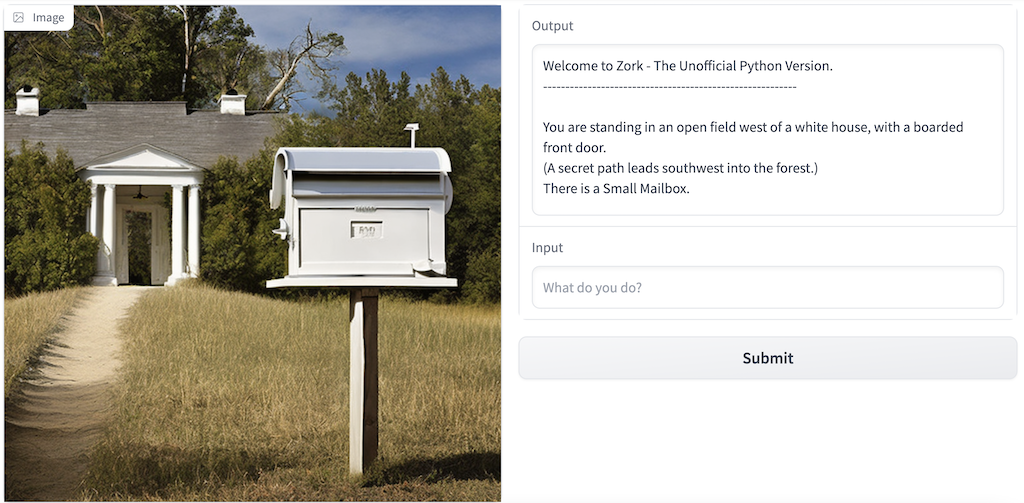

> Warning: because the models are huge and here we are running on Colab, thus generating images is very slow (it takes around 2mn) which leads to a very poor interactions.

## That's all folks

Stable Diffusion is a very neat model allowing the generation of images from text. In this article, we explored the use case of remaking a text-based game with Stable Diffusion.

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc).